<a href="https://colab.research.google.com/github/andreianmatos/temporal_spaces_texture_gen/blob/main/CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright: [Tensorflow's DCGAN tutorial](https://www.tensorflow.org/tutorials/generative/dcgan?hl=en) and [Tensorflow's CVAE tutorial](https://www.tensorflow.org/tutorials/generative/cvae?hl=en)


# Setup

In [43]:
!pip install tensorflow-probability
!pip install tensorflow-docs

# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
import time
from IPython import display
import requests
from io import BytesIO
from zipfile import ZipFile
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow_docs.vis.embed as embed

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-2ash22hk
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-2ash22hk
  Resolved https://github.com/tensorflow/docs to commit d13c500b2e552ce04095287a99c575d2685a2160
  Preparing metadata (setup.py) ... done


In [44]:
tf.__version__

'2.15.0'

In [45]:
# Create the directories
cvae_directory_path = os.path.join('CVAE')
os.makedirs(cvae_directory_path, exist_ok=True)

Training the movement's textures on:

- Deep Convolutional Generative Adversarial Network
- Convolutional Variational Autoencoder

# Load and Prepare the Dataset

We will use the [movement's texture](https://github.com/andreianmatos/temporal_spaces_texture_gen/tree/main/datasets) dataset.

In [46]:
dataset_link = 'https://github.com/andreianmatos/temporal_spaces_texture_gen/raw/main/datasets/captures.zip'

# Fetch the zip file content
response = requests.get(dataset_link)
zip_data = BytesIO(response.content)

# Extract the contents of the zip file
with ZipFile(zip_data, 'r') as zip_ref:
    zip_ref.extractall()

dataset_path = 'captures'

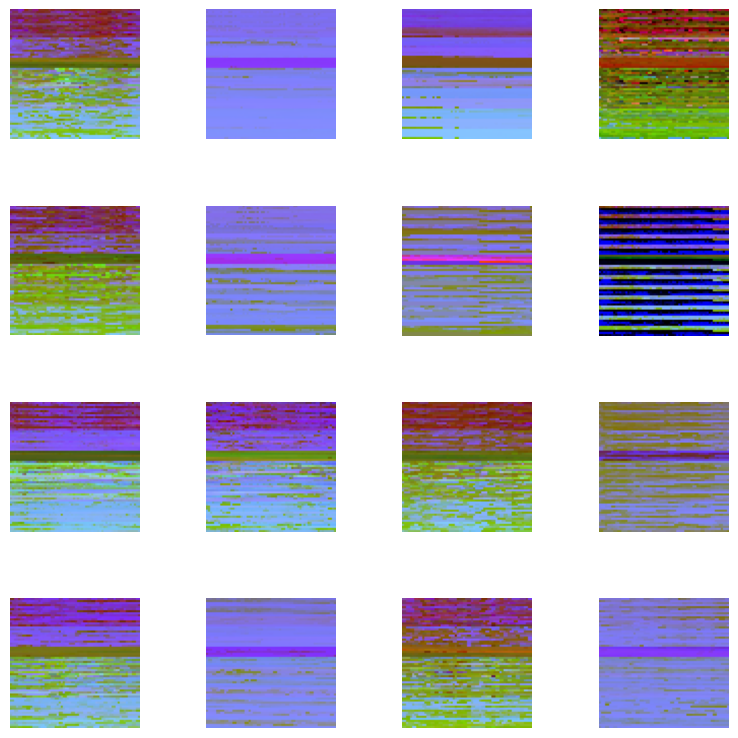

In [47]:
# Define the path to your dataset
image_files = [os.path.join(dataset_path, file) for file in os.listdir(dataset_path) if file.endswith('.png')]

images = []
# Loop through each image file and load the image
for image_file in image_files:
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Resize the image to your desired size
    # image = cv2.resize(image, (28, 28))
    # Normalize pixel values to the range [0, 1] and save as float32
    image = image.astype(np.float32) / 255.0
    images.append(image)

train_images = np.array(images, dtype=np.float32)

np.save('preprocessed_train_images.npy', train_images)

# Display images in a grid
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout()

for i in range(4):
    for j in range(4):
        axs[i, j].imshow(train_images[i * 4 + j])
        axs[i, j].axis('off')

plt.show()

# Convolutional Variational Autoencoder

This notebook demonstrates how to train a Variational Autoencoder (VAE) ([1](https://arxiv.org/abs/1312.6114), [2](https://arxiv.org/abs/1401.4082)) on our dataset. A VAE is a probabilistic take on the autoencoder, a model which takes high dimensional input data and compresses it into a smaller representation. Unlike a traditional autoencoder, which maps the input onto a latent vector, a VAE maps the input data into the parameters of a probability distribution, such as the mean and variance of a Gaussian. This approach produces a continuous, structured latent space, which is useful for image generation.




<div>
<img src="https://github.com/andreianmatos/temporal_spaces_texture_gen/blob/main/results/cvae_gif.gif?raw=true" width="500"/>
</div>

### Dataset Preprocessing

In [48]:
#os.chdir("content/")
os.chdir(cvae_directory_path)
current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")

Current working directory: /content/CVAE/generated_images/generated_images/generated_images/CVAE


In [49]:
# Assuming train_images is your preprocessed dataset
train_images, test_images = train_test_split(train_images, test_size=0.2, random_state=42)

# Save the datasets to separate files
np.save('preprocessed_train_split_images.npy', train_images)
np.save('preprocessed_test_split_images.npy', test_images)

## Add a channel dimension if it doesn't exist
if len(train_images.shape) == 3:
    train_images = train_images[..., tf.newaxis]
if len(test_images.shape) == 3:
    test_images = test_images[..., tf.newaxis]

### Apply Data Augmentation to Training Dataset

In [50]:
def apply_data_augmentation(image):
    # horizontal flip
    image = tf.image.random_flip_left_right(image)
    # vertical flip
    image = tf.image.random_flip_up_down(image)
    # brightness
    image = tf.image.random_brightness(image, max_delta=0.2)
    # contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    # saturation
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    image = tf.clip_by_value(image, 0.0, 1.0)

    return image

New dataset size: 39600


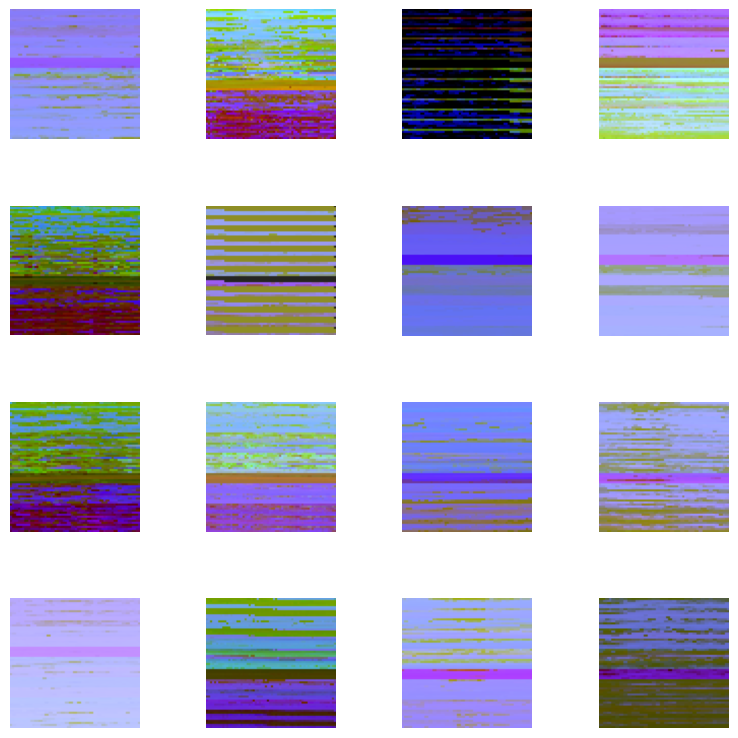

In [51]:
num_repeats = 50

augmented_train_images = []
for _ in range(num_repeats):
    augmented_images = np.array([apply_data_augmentation(image) for image in train_images], dtype=np.float32)
    augmented_train_images.extend(augmented_images)

print("New dataset size:",len(augmented_train_images))

# Display images in a grid
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout()

for i in range(4):
    for j in range(4):
        axs[i, j].imshow(augmented_train_images[i * 4 + j])
        axs[i, j].axis('off')

plt.show()

In [52]:
from google.colab import drive# Save images to a folder on Google Drive
output_folder = '/content/drive/MyDrive/Augmented_Images'  # Update with your desired folder path

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Save each image in the output folder
for i, image in enumerate(augmented_train_images):
    plt.imsave(os.path.join(output_folder, f'augmented_image_{i}.png'), image)


In [10]:
# Combine original and augmented datasets
combined_train_images = np.concatenate((train_images, augmented_train_images), axis=0)
# Shuffle
shuffled_combined_train_images = tf.random.shuffle(combined_train_images)

np.save('augmented_train_images.npy', shuffled_combined_train_images)

In [14]:
train_images = combined_train_images

### Use *tf.data* to batch and shuffle the data

In [15]:
train_size = 1000 #
batch_size = 32
test_size = 200
buffer_size = 1000

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(buffer_size).batch(batch_size)

## Define the encoder and decoder networks with *tf.keras.Sequential*

In this VAE example, use two small ConvNets for the encoder and decoder networks. In the literature, these networks are also referred to as inference/recognition and generative models respectively. Use `tf.keras.Sequential` to simplify implementation. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Encoder network
This defines the approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation $z$.
In this example, simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian.
Output log-variance instead of the variance directly for numerical stability.

### Decoder network
This defines the conditional distribution of the observation $p(x|z)$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation.
Model the latent distribution prior $p(z)$ as a unit Gaussian.

### Reparameterization trick
To generate a sample $z$ for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $x$.
However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, use a reparameterization trick.
In our example, you approximate $z$ using the decoder parameters and another parameter $\epsilon$ as follows:

$$z = \mu + \sigma \odot \epsilon$$

where $\mu$ and $\sigma$ represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The $\epsilon$ can be thought of as a random noise used to maintain stochasticity of $z$. Generate $\epsilon$ from a standard normal distribution.

The latent variable $z$ is now generated by a function of $\mu$, $\sigma$ and $\epsilon$, which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

### Network architecture
For the encoder network, use two convolutional layers followed by a fully-connected layer. In the decoder network, mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.


In [16]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(64, 64, 3)),  # Change input shape
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=16 * 16 * 32, activation=tf.nn.relu),  # Adjust units
                tf.keras.layers.Reshape(target_shape=(16, 16, 32)),  # Adjust target shape
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=3, kernel_size=3, strides=1, padding='same'),
            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits


## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

Note: You could also analytically compute the KL term, but here you incorporate all three terms in the Monte Carlo estimator for simplicity.

In [17]:
optimizer = tf.keras.optimizers.legacy.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  # Adjust the axis parameter in reduce_sum to consider the number of channels
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])  # Adjust axis for RGB images

  # Adjust the axis parameter in reduce_sum to consider the number of channels
  logpz = log_normal_pdf(z, 0., 0., raxis=1)  # Adjust axis for RGB images
  logqz_x = log_normal_pdf(z, mean, logvar, raxis=1)  # Adjust axis for RGB images

  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))


## Training

* Start by iterating over the dataset
* During each iteration, pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$
* Note: Since you use the dataset loaded by keras with 60k datapoints in the training set and 10k datapoints in the test set, our resulting ELBO on the test set is slightly higher than reported results in the literature which uses dynamic binarization of Larochelle's MNIST.

### Generating images

* After training, it is time to generate some images
* Start by sampling a set of latent vectors from the unit Gaussian prior distribution $p(z)$
* The generator will then convert the latent sample $z$ to logits of the observation, giving a distribution $p(x|z)$
* Here, plot the probabilities of Bernoulli distributions


In [18]:
epochs = 100
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [19]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

def generate_image(model, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    prediction = model.sample(z)[0]
    image = np.array(prediction * 255, dtype=np.uint8)
    image = Image.fromarray(image)
    return image

In [20]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

In [21]:
# Set the main log directory
main_log_dir = "logs/"
# Create a unique subdirectory for each run based on the current timestamp
current_time = time.strftime("%Y%m%d-%H%M%S")
log_dir = f"{main_log_dir}{current_time}/"

Epoch: 100, Test set ELBO: -7663.46728515625, time elapse for current epoch: 8.14595341682434


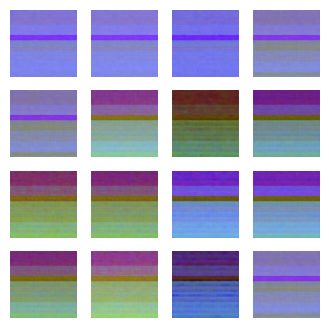

In [22]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()

  # Log to TensorBoard
  with tf.summary.create_file_writer(log_dir).as_default():
    tf.summary.scalar('Test ELBO', elbo, step=epoch)

  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

In [23]:
#print(f"Run 'tensorboard --logdir {main_log_dir}' to visualize the results.")
#!tensorboard --logdir logs/

### Display an animated GIF of all the saved images

In [35]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-35-a6dbd3b71488>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-35-a6dbd3b71488>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



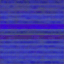

In [36]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

### Display a 2D manifold of textures from the latent space

Running the code below will show a continuous distribution of the different textures, with each morphing into another across the 2D latent space. See: [TensorFlow Probability](https://www.tensorflow.org/probability) to generate a standard normal distribution for the latent space.

In [37]:
def plot_latent_images(model, n, image_size=64):
    """Plots n x n digit images decoded from the latent space."""

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = image_size * n
    image_height = image_size * n
    image = np.zeros((image_height, image_width, 3))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            # Assuming x_decoded is in the range [0, 1] for RGB images
            digit = tf.reshape(x_decoded[0], (image_size, image_size, 3))
            image[i * image_size: (i + 1) * image_size,
                  j * image_size: (j + 1) * image_size, :] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

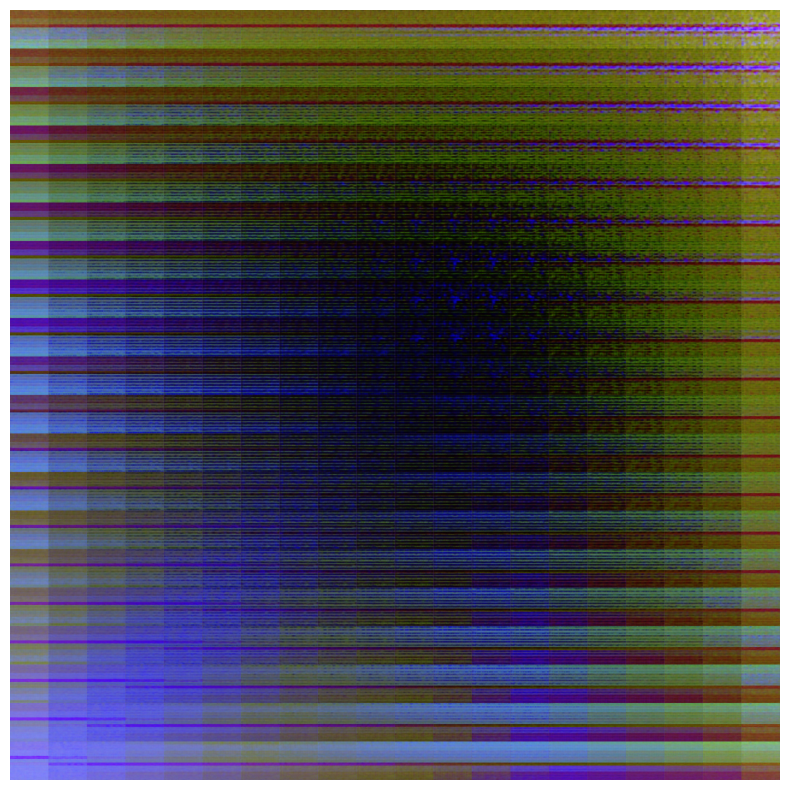

In [38]:
plot_latent_images(model, 20)

## Generate Images

Create image generation loop + save images.

In [41]:
if not os.path.exists('generated_images'):
  os.makedirs('generated_images')
os.chdir('generated_images')

num_examples_to_generate = 1
image_size = 64
num_channels = 3
nr_images_to_generate = 32
generated_images = []

for i in range(nr_images_to_generate):
  # see tensorflow probability
  sample = tf.random.normal([num_examples_to_generate, image_size, image_size, num_channels], mean=0.5, stddev=0.2, seed=None)
  #sample = tf.random.uniform([num_examples_to_generate, image_size, image_size, num_channels], minval=0.0, maxval=1.0, seed=None)
  image = generate_image(model, sample)
  image.save('image_{:d}.png'.format(i))
  generated_images.append(image)

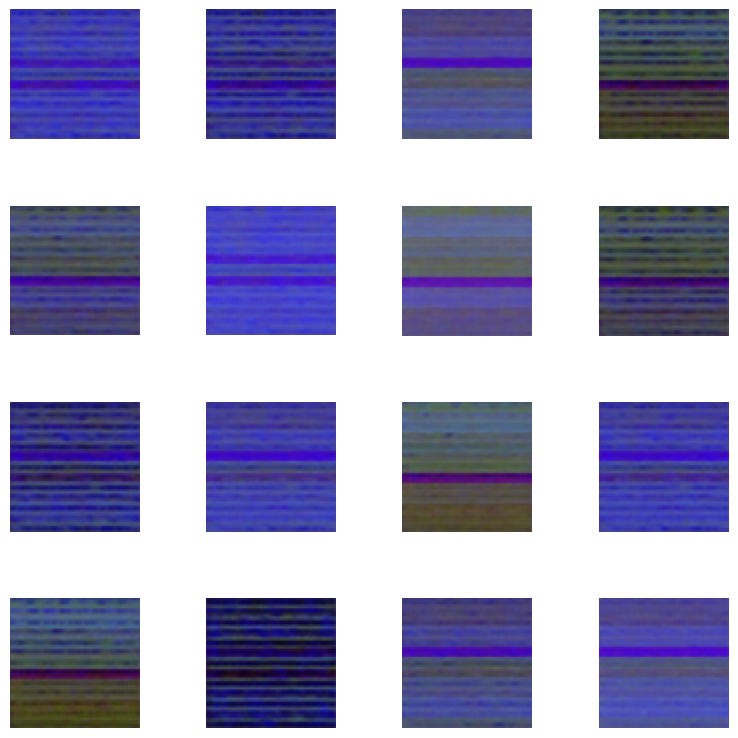

In [42]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout()

for i in range(4):
    for j in range(4):
        axs[i, j].imshow(generated_images[i * 4 + j])
        axs[i, j].axis('off')

plt.show()